In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
trade_df= pd.read_csv("BTC-USD.csv")

In [3]:
trade_df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,01/06/2014,669.429993,669.780029,602.099976,651.049988,651.049988,12872108
1,08/06/2014,651.049988,663.039978,560.849976,582.289978,582.289978,19756894
2,15/06/2014,582.289978,614.400024,580.450012,603.619995,603.619995,13622438
3,22/06/2014,603.619995,608.760010,565.849976,601.059998,601.059998,13164158
4,29/06/2014,601.059998,652.539978,596.549988,626.650024,626.650024,16775774


In [4]:
trade_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 262 entries, 0 to 261
Data columns (total 7 columns):
Date         262 non-null object
Open         262 non-null float64
High         262 non-null float64
Low          262 non-null float64
Close        262 non-null float64
Adj Close    262 non-null float64
Volume       262 non-null int64
dtypes: float64(5), int64(1), object(1)
memory usage: 14.4+ KB


In [5]:
trade_df=trade_df.drop(columns=['Open','High','Low','Close','Volume'])

## This is just one column ..so we will need it split in 2 columns by skipping row 1

In [6]:
trade_df.rename(columns={'Date':'Week'}, 
                 inplace=True)

In [7]:
trade_df.head()

,Week,Adj Close
0,01/06/2014,651.049988
1,08/06/2014,582.289978
2,15/06/2014,603.619995
3,22/06/2014,601.059998
4,29/06/2014,626.650024


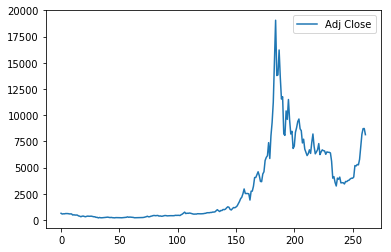

In [8]:
trade_df.plot()

In [9]:
from datetime import datetime
trade_df['Week']=  pd.to_datetime(trade_df['Week']).dt.strftime('%d/%m/%y')
#trade_df['Week1']=  trade_df['Week'].dt.strftime('%Y-%m-%d')

#trade_df['Week1'] = datetime.strftime(trade_df['Week'], '%m/%d/%y')

In [143]:
trade_df.head()

,Adj Close
Week,
2014-06-01,651.049988
2014-06-08,582.289978
2014-06-15,603.619995
2014-06-22,601.059998
2014-06-29,626.650024


In [11]:
trade_df['Week']=  pd.to_datetime(trade_df['Week'])

In [12]:
type(trade_df.index)

pandas.core.indexes.range.RangeIndex

In [144]:
trade_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 262 entries, 2014-06-01 to 2019-06-02
Data columns (total 1 columns):
Adj Close    262 non-null float64
dtypes: float64(1)
memory usage: 14.1 KB


In [14]:
#trade_df.reset_index()
trade_df.set_index('Week', inplace=True  )
#trade_df['Week'] = pd.DatetimeIndex(start ='2014-06-01', end='2019-06-04', freq ='w') 

In [15]:
type(trade_df.index)

pandas.core.indexes.datetimes.DatetimeIndex

In [16]:
trade=trade_df # ['Adj Close']


# above is a series of data ..
# trade.reset_index()

In [17]:
trade_df.head()

,Adj Close
Week,
2014-06-01,651.049988
2014-06-08,582.289978
2014-06-15,603.619995
2014-06-22,601.059998
2014-06-29,626.650024


In [18]:
trade_df.head()

,Adj Close
Week,
2014-06-01,651.049988
2014-06-08,582.289978
2014-06-15,603.619995
2014-06-22,601.059998
2014-06-29,626.650024


In [19]:
type(trade_df)

pandas.core.frame.DataFrame

# model ARIMA(p,d,q)

# decomposing time series data 
1. seasonality
2. peak in some time of year
3. repetative beahiviur
4. residual: nosie
    

In [20]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition=seasonal_decompose(trade_df, model='additive', freq=52 )

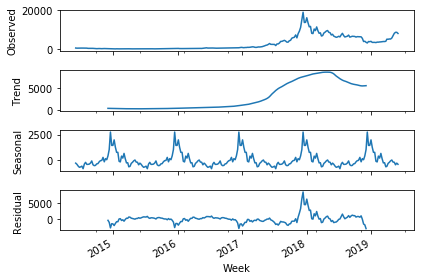

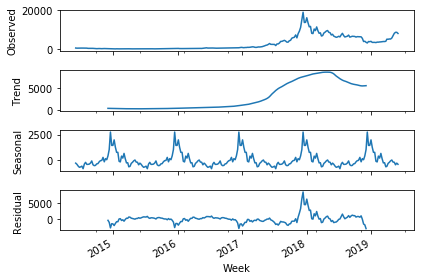

In [21]:
decomposition.plot()

In [22]:
trend= decomposition.trend
seasonal=decomposition.seasonal
residual=decomposition.resid

    

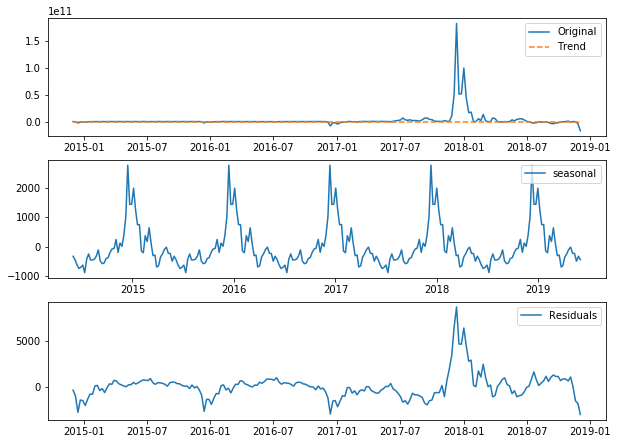

In [23]:
plt.figure(figsize=(10,10))
plt.figure(1)
plt.subplot(411)
plt.plot(trend*seasonal*residual, label='Original')
plt.plot(trend,label='Trend',linestyle='--')
plt.legend(loc='best')


plt.subplot(412)

plt.plot(seasonal,label='seasonal' )
plt.legend(loc='best')

plt.subplot(413)

plt.plot(residual,label='Residuals')
plt.legend(loc='best')




# (Partial) Autocorrelation Function

In [28]:
decomposition=seasonal_decompose(diff, model='additive', freq=52)

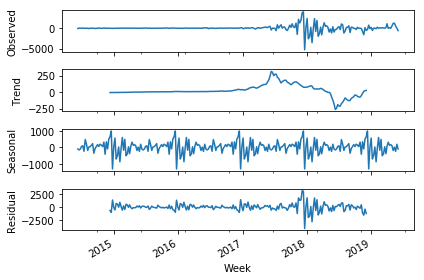

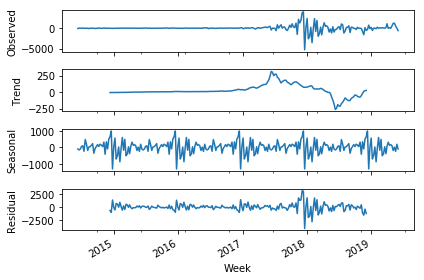

In [29]:
decomposition.plot()

# Building ARIMA model

In [104]:
trade_df.head()

,Adj Close
Week,
2014-01-06,651.049988
2014-08-06,582.289978
2014-06-15,603.619995
2014-06-22,601.059998
2014-06-29,626.650024


In [66]:
# limit to after 2017 data

#mask = ( trade_df['Week']  > '2017-12-01')
#trade_df_limited = trade_df.loc[(mask)]

#trade_df_limited= trade_df[(trade_df['Week'] > '2017-12-01') ]

trade_df_limit=trade_df.loc['2018-01-01':'2019-06-02']



In [68]:
trade_df_limit.head()

,Adj Close
Week,
2018-01-01,16228.160160
2018-01-08,13638.629880
2018-01-15,11549.929690
2018-01-22,11767.740230
2018-01-29,8218.049805


In [69]:
ts = trade_df_limit['Adj Close']

In [70]:
# These are the relevant libraries we'll use.
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima_model import ARIMA

In [71]:
# This method finds the MSE of a single ARIMA model.
def evaluate_arima_model(data, arima_order):
    split=int(len(data) * 0.8) # Needs to be an integer because it is later used as an index.
    train, test = data[0:split], data[split:len(data)]
    past=[x for x in train]
    # make predictions
    predictions = list()
    for i in range(len(test)):#timestep-wise comparison between test data and one-step prediction ARIMA model. 
        model = ARIMA(past, order=arima_order)
        model_fit = model.fit(disp=0)
        future = model_fit.forecast()[0]
        predictions.append(future)
        past.append(test[i])
    # calculate out of sample error
    error = mean_squared_error(test, predictions)
    return error

In [139]:
# This method evaluates ARIMA models with several different p, d, and q values.
def evaluate_models(dataset, p_values, d_values, q_values):
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                print(order)
                try:
                    
                    mse = evaluate_arima_model(dataset, order)
                    if mse < best_score:
                        best_score, best_cfg = mse, order
                    print('ARIMA%s MSE=%.3f' % (order,mse))
                except:
                    continue
    return print('Best ARIMA%s MSE=%.3f' % (best_cfg, best_score))

In [140]:
# Now, we choose a couple of values to try for each parameter.
p_values = [x for x in range(0, 3)]
d_values = [x for x in range(0, 3)]
q_values = [x for x in range(0, 3)]

In [142]:
import warnings
#warnings.filterwarnings("ignore")
evaluate_models(ts , p_values, d_values, q_values)

(0, 0, 0)
ARIMA(0, 0, 0) MSE=4389075.437
(0, 0, 1)
ARIMA(0, 0, 1) MSE=1347299.676
(0, 0, 2)
ARIMA(0, 0, 2) MSE=756208.197
(0, 1, 0)
ARIMA(0, 1, 0) MSE=457776.441
(0, 1, 1)
ARIMA(0, 1, 1) MSE=465323.966
(0, 1, 2)
ARIMA(0, 1, 2) MSE=437401.083
(0, 2, 0)
ARIMA(0, 2, 0) MSE=284750.915
(0, 2, 1)
ARIMA(0, 2, 1) MSE=267822.153
(0, 2, 2)
(1, 0, 0)
ARIMA(1, 0, 0) MSE=295238.509
(1, 0, 1)
ARIMA(1, 0, 1) MSE=287831.194
(1, 0, 2)
ARIMA(1, 0, 2) MSE=295495.345
(1, 1, 0)
ARIMA(1, 1, 0) MSE=465468.017
(1, 1, 1)
(1, 1, 2)
(1, 2, 0)
ARIMA(1, 2, 0) MSE=340890.361
(1, 2, 1)
ARIMA(1, 2, 1) MSE=277429.078
(1, 2, 2)
(2, 0, 0)
ARIMA(2, 0, 0) MSE=287059.080
(2, 0, 1)
(2, 0, 2)
(2, 1, 0)
ARIMA(2, 1, 0) MSE=451944.902
(2, 1, 1)
ARIMA(2, 1, 1) MSE=587072.497
(2, 1, 2)
(2, 2, 0)
ARIMA(2, 2, 0) MSE=445671.094
(2, 2, 1)
ARIMA(2, 2, 1) MSE=435506.036
(2, 2, 2)
Best ARIMA(0, 2, 1) MSE=267822.153


In [100]:
p=2
d=0
q=1
model = ARIMA(ts, order=(p,d,q))
model_fit = model.fit()
forecast = model_fit.forecast(1)

In [101]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:              Adj Close   No. Observations:                   75
Model:                     ARMA(2, 1)   Log Likelihood                -618.308
Method:                       css-mle   S.D. of innovations            890.849
Date:                Mon, 19 Aug 2019   AIC                           1246.616
Time:                        10:55:54   BIC                           1258.203
Sample:                             0   HQIC                          1251.243
                                                                              
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const            9571.0627   2766.674      3.459      0.001    4148.480     1.5e+04
ar.L1.Adj Close     1.9791      0.022     90.126      0.000       1.936       2.022
ar.L2.Adj Close    -0.9814      0.021    -46.282      0.000      -1.023      -0.940
ma.L1.Adj Close    -0.9990      0.037    -27.320      0.000      -1.071      -0.927
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0083           -0.0478j            1.0094           -0.0075
AR.2            1.0083           +0.0478j            1.0094            0.0075
MA.1            1.0010           +0.0000j            1.0010            0.0000
-----------------------------------------------------------------------------
"""

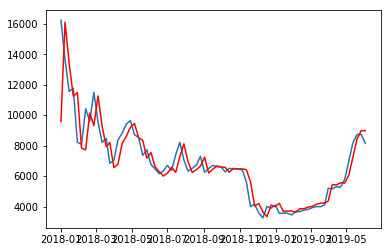

In [102]:
plt.plot(ts)
plt.plot(model_fit.predict(), color = 'red')

In [103]:
periods_to_forecast = 30
date_range = pd.date_range(ts.index[-1], periods = periods_to_forecast,
              freq='W').strftime("%Y-%m-%d").tolist()
forecast = model_fit.forecast(periods_to_forecast)
# Turn that range into a dataframe that includes your predictions
future_days = pd.DataFrame(date_range, columns = ['Days'])
future_days['Days'] = pd.to_datetime(future_days['Days'])
future_days.set_index('Days', inplace = True)

In [104]:
future_days['Prediction'] = forecast[0]

In [105]:
future_days.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 30 entries, 2019-06-02 to 2019-12-22
Data columns (total 1 columns):
Prediction    30 non-null float64
dtypes: float64(1)
memory usage: 480.0 bytes


In [106]:
trade_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 262 entries, 2014-06-01 to 2019-06-02
Data columns (total 1 columns):
Adj Close    262 non-null float64
dtypes: float64(1)
memory usage: 14.1 KB


In [107]:
future_days.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 30 entries, 2019-06-02 to 2019-12-22
Data columns (total 1 columns):
Prediction    30 non-null float64
dtypes: float64(1)
memory usage: 480.0 bytes


In [108]:
type(future_days.index)

pandas.core.indexes.datetimes.DatetimeIndex

In [109]:
type(trade_df.index)

pandas.core.indexes.datetimes.DatetimeIndex

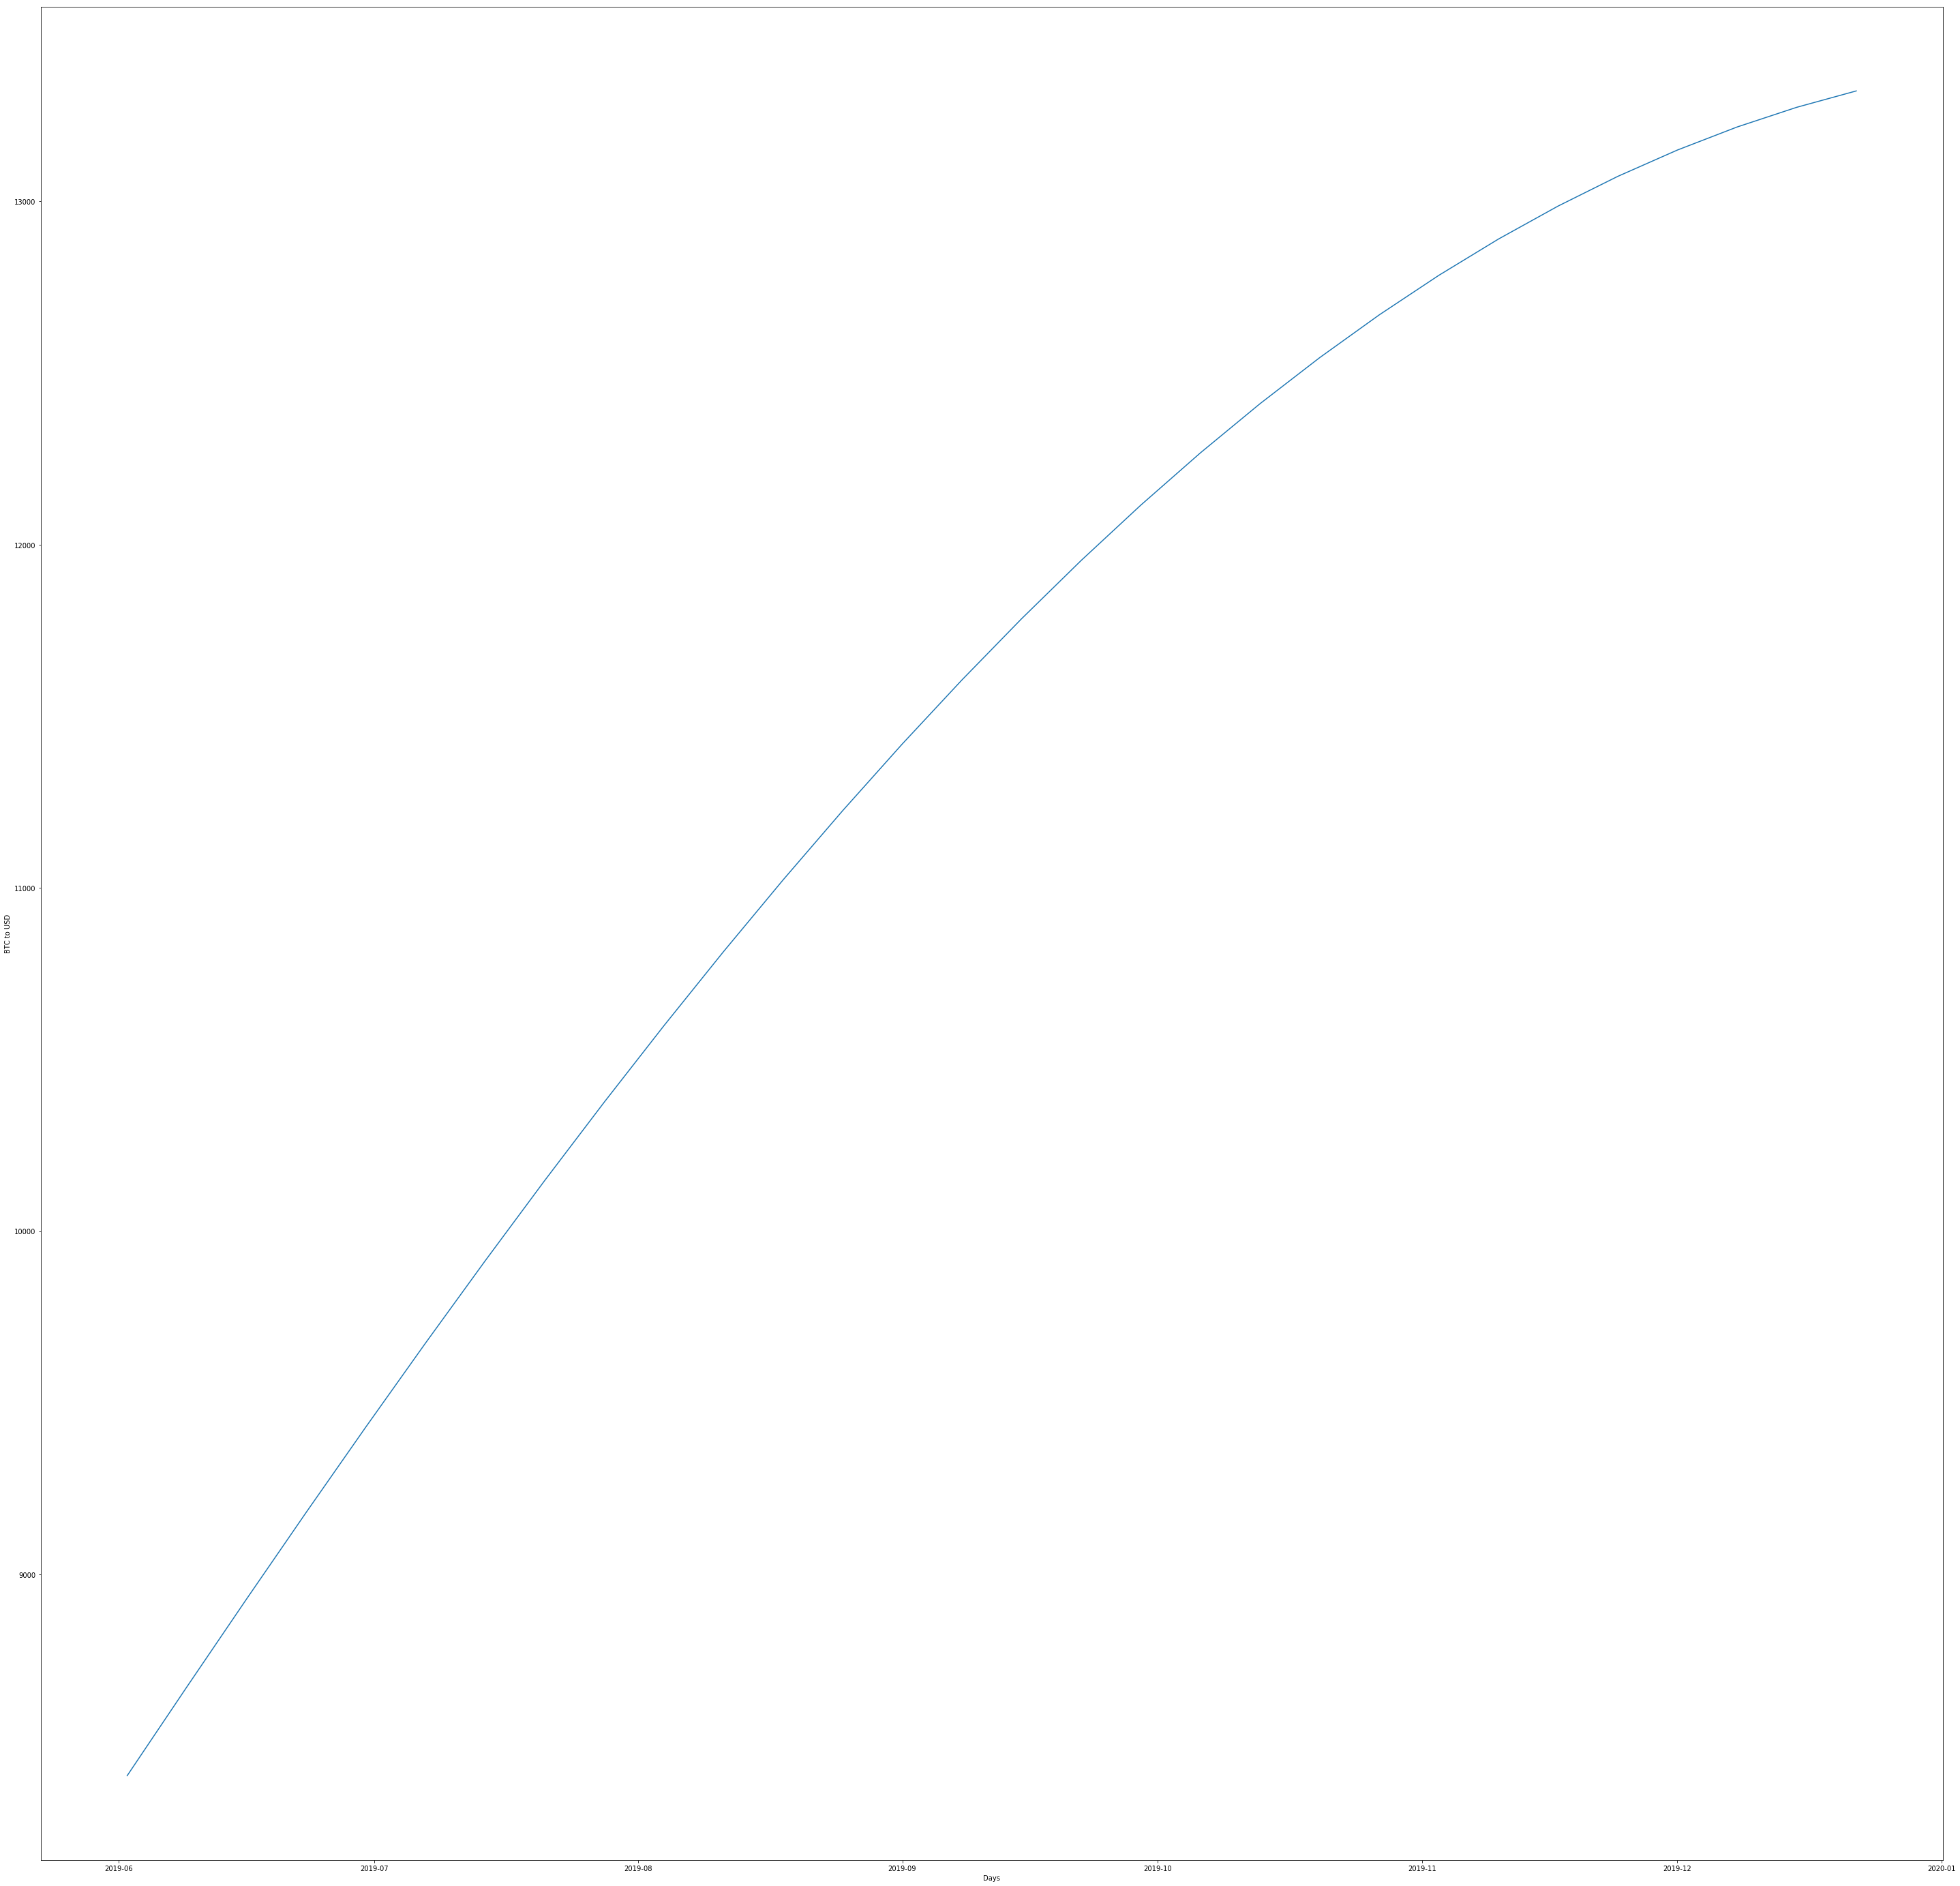

In [111]:
plt.figure(figsize=(50,50))
#plt.plot(ts)
plt.plot(future_days)
plt.xlabel ("Days")
plt.ylabel("BTC to USD")
plt.show()